In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import pandas as pd

from utils.basic_utils import read_dates, load_csvs, csv_load
from utils.pricing import *
from utils.fundamental import filter_cols
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.3f}'.format

Loading utils/config.json


In [3]:
# utility functions
def top_recomm_by_class(pred_df, labels, top_items):
    mask = pred_df.hard_pred_label == pred_df.soft_pred_label
    agree_df = pred_df.loc[mask].drop_duplicates()
    # should add sector and industries, group for allocation insights
    # should add marketcap, beta, etc, group for risk exposure insights
    label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
    return agree_df.loc[label_mask]\
        .sort_values(by='soft_confidence', ascending=False)\
        .groupby(by='soft_pred_label').head(top_items)\
        .sort_values(by='soft_pred_class')

def pred_distrib(pred_df, count_col):
    dist = pd.value_counts(pred_df[count_col]).to_frame()
    dist['weights'] = dist / dist.sum()
    return dist

def add_desc_stats(df, descriptive_cols):
    
    tickers = df.index
    for k in descriptive_cols.keys():
        desc_df, cols = descriptive_cols[k]['df'], descriptive_cols[k]['columns']
        for c in cols: df.loc[:, c] = tickers.map(desc_df[c].to_dict()).values 

    df = clean_df(df, large_vals, div_cols)

    df.loc[:, 'pegRatio'] = df.forwardPE / (val_df.growthRate * 100)
    df.loc[:, 'size'] = discret_rets(df.marketCap, mkt_cap_cuts, mkt_cap_labels)
        
    return df

def clean_df(df, large_vals, div_cols):
    # convert large values to billions
    df.loc[:, large_vals] = df.loc[:, large_vals] / 10**9
    df.loc[:, div_cols] = df[div_cols].div(df.regularMarketPrice, axis=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

def ml_votes_by_class(fndm_dfs, group_mask):
    super_list = []
    for key in fndm_dfs.keys():
        df = fndm_dfs[key]
        super_list.append(
            fndm_dfs[key].loc[:, group_mask].set_index(re_index_col)\
            .rename(columns={group_mask[0]: key}))
    df = pd.concat(super_list, axis=1, sort=False)
    # df.apply(pd.value_counts).loc[fwd_ret_labels].style.background_gradient(cmap='RdYlGn')
    return df.T.apply(pd.value_counts).T

q_group = lambda x, q: x.quantile(q)

ticker_across_mls = lambda ticker: pd.concat(
    [fndm_dfs[key] for key in fndm_dfs.keys()]
    ).set_index('symbol').loc[ticker]

# equal weight ml_confidence
equal_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[:, x[1]].mean()

# take index and class, and calculate a dot product, weighted confidence
score_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[
    :, [x[1], 'model']].set_index('model').T.mul(model_weights).sum(1).iloc[0]

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "../"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout: plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, )

In [5]:
hard_vote, soft_vote = 'hard_pred_label', 'soft_pred_label'

In [6]:
# s3 paths
s3_path = {
    'macro': 'recommend/macro_ML/',
    'px_mom': 'recommend/micro_ML/',
    'fin_data': 'recommend/fdmn_ML-fin_data/',
    'key_statistics': 'recommend/fdmn_ML-key_statistics/',
    'eps_trend': 'recommend/fdmn_ML-eps_trend/',
    'eps_estimates': 'recommend/fdmn_ML-eps_estimates/',
    'day_quote': 'recommend/fdmn_ML-day_quote/',
    'iv_value': 'valuation/waterfall/'
}

In [21]:
# environment variables
bench = '^GSPC'
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
show_classes = ['bear', 'short', 'long', 'bull']

key = 'fin_data'
agg_funcs = ['count', 'median', 'max']
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

re_index_col = 'symbol'
value_col = 'soft_confidence'
show = ['symbol', 'soft_confidence']
mask_col, class_value = 'soft_pred_label', 'bull'

large_vals = ['marketCap']
div_cols = ['targetMeanPrice', 'targetMedianPrice']

In [8]:
# context / descriptive data
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3

quotes = load_csvs('quote_consol', [tgt_date])
eqty_symbols = quotes[quotes.quoteType == 'EQUITY'].symbol
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date)])
keystats.set_index('symbol', drop=False, inplace=True)
1
finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date)])
finstats.set_index('symbol', drop=False, inplace=True)

path = 'valuation/waterfall/'
print(f'Loading {path}{tgt_date}')
val_df = pd.read_csv(csv_load(path+tgt_date), parse_dates=True)
val_df.set_index('symbol', inplace=True)
val_df.dropna(subset=['premDisc'], inplace=True)
val_df = val_df.loc[(np.abs(val_df.premDisc) < val_df.premDisc.median() * 3).values, :]

descriptive_cols = {
    'quotes': { 'df': quotes, 'columns': ['shortName', 'forwardPE', 'trailingPE', 'marketCap', 'regularMarketPrice'],},
    'profile': { 'df': profile, 'columns': ['sector', 'industry', 'country'],},
    'keystats': { 'df': keystats, 'columns': ['pegRatio', 'shortPercentOfFloat'],},
    'finstats': { 'df': finstats, 'columns': ['earningsGrowth', 'recommendationMean', 'targetMeanPrice', 'targetMedianPrice', 'numberOfAnalystOpinions'],},
    'valuation': { 'df': val_df, 'columns': ['premDisc', 'growthRate'],},
}

Loading file quote/csv/2019-04-10
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-04-10
Loading file summary-categories/financialData/2019-04-10
Loading valuation/waterfall/2019-04-10


### Macro / risk-exposure ML

In [9]:
# Read macro predictions
key = 'macro'
macro_df = pd.read_csv(csv_load(f'{s3_path[key]}{tgt_date}'), index_col='pred_date', parse_dates=True)
macro_df.tail()

,^GSPC,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,,,
2019-04-04,"2,879.390",3,long,3,long,0.667,0.000,0.014,0.299,0.667,0.020
2019-04-05,"2,892.740",3,long,3,long,0.599,0.000,0.035,0.358,0.599,0.008
2019-04-08,"2,895.770",3,long,3,long,0.601,0.000,0.022,0.370,0.601,0.008
2019-04-09,"2,878.200",3,long,3,long,0.771,0.000,0.014,0.200,0.771,0.015
2019-04-10,"2,888.210",3,long,3,long,0.718,0.000,0.021,0.247,0.718,0.013


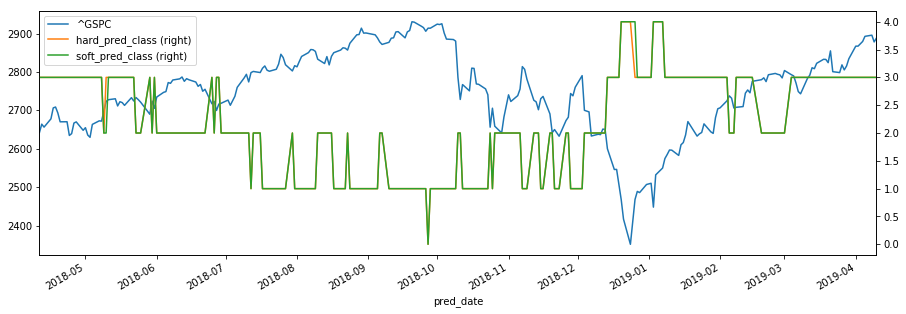

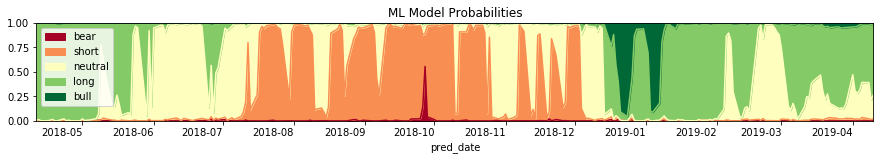

In [10]:
# Visualize macro predictions
pred_df = macro_df
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, 
    figsize=(15, 5));
plt.savefig('../images/macro_chart.png', dpi=300, rot=0)
pred_df[fwd_ret_labels].plot.area(
        title='ML Model Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0);
f'Confidence Mean: {pred_df["soft_confidence"].mean().round(3)}, \
    Median {pred_df["soft_confidence"].median().round(3)}'
plt.savefig('../images/macro_prob.png', dpi=300)

### Bottom-up MLs

In [11]:
# Read ML predictions
fndm_dfs = {
    k: pd.read_csv(
        csv_load(f'{s3_path[k]}{tgt_date}'), 
        index_col='pred_date', 
        parse_dates=True)\
        for k in ('px_mom', 'fin_data', 'key_statistics', 
                  'eps_trend', 'eps_estimates', 'day_quote')
}
for key in fndm_dfs.keys(): 
    fndm_dfs[key].loc[:, 'model'] = key

PX_MOM, 1164 unique symbols
FIN_DATA, 1154 unique symbols
KEY_STATISTICS, 1176 unique symbols
EPS_TREND, 1209 unique symbols
EPS_ESTIMATES, 1209 unique symbols
DAY_QUOTE, 1301 unique symbols

Class probability distribution across ML models


,px_mom,fin_data,key_statistics,eps_trend,eps_estimates,day_quote
bear,0.088,0.020,0.042,0.031,0.031,0.071
short,0.130,0.211,0.230,0.280,0.259,0.258
neutral,0.017,0.395,0.255,0.252,0.267,0.188
long,0.292,0.352,0.451,0.402,0.404,0.441
bull,0.473,0.022,0.022,0.034,0.039,0.041


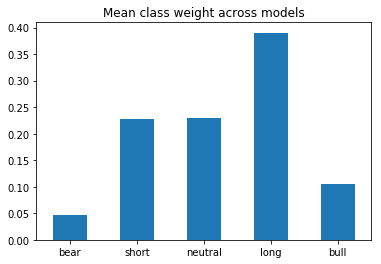

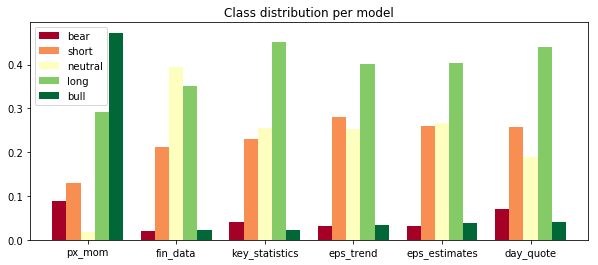

In [40]:
# Class distribution across models
super_list = []
for key in fndm_dfs.keys():
    df = fndm_dfs[key]
    print(f'{key.upper()}, {df.symbol.shape[0]} unique symbols')
    pred_df = pred_distrib(df, soft_vote).loc[fwd_ret_labels, 'weights']
    pred_df.name = key
    super_list.append(pred_df)
    
class_distrib = pd.concat(super_list, axis=1, sort=True).loc[fwd_ret_labels, :]
class_distrib.mean(axis=1).plot.bar(
    title='Mean class weight across models', rot=0)
plt.savefig('../images/ML_mean_weight.png', dpi=300, rot=0)

class_distrib.T.plot.bar(
    title='Class distribution per model', stacked=False, 
    cmap='RdYlGn', figsize=(10,4), width=0.8, rot=0,)
plt.savefig('../images/ML_class_dristrib.png', dpi=300, rot=0)

print('\nClass probability distribution across ML models')
class_distrib

#### ML weights

In [15]:
# Model score weights 
ml_score_dict = {
    'px_mom': 0.75, 'fin_data': 0.75, 'key_statistics': 0.7, 
    'eps_trend': 0.68, 'eps_estimates': 0.65, 
    'day_quote': 0.6, 
    'intrinsic_val': 0.7
}

model_scores = np.array(list(map(ml_score_dict.get, fndm_dfs.keys())))
adj_weights = (model_scores - 0.5) / (model_scores - 0.5).sum()
model_weights = pd.Series({x:y for x,y in zip(fndm_dfs.keys(), adj_weights)})

print('Model weights')
model_weights

Model weights


px_mom           0.221
fin_data         0.221
key_statistics   0.177
eps_trend        0.159
eps_estimates    0.133
day_quote        0.088
dtype: float64

### Filtered recomendations

In [16]:
# filter settings
min_confidence = 0.55
max_rows = 20

In [17]:
ml_votes_df = ml_votes_by_class(fndm_dfs, [re_index_col, 'soft_pred_label'])
ml_votes_df = ml_votes_df.loc[ml_votes_df.index.isin(eqty_symbols), :]
min_consensus = ml_votes_df[(ml_votes_df > 3).values]

In [18]:
label_pos = np.argmax(min_consensus[fwd_ret_labels].fillna(0).values, axis=1)

In [19]:
vote_df = pd.DataFrame([fwd_ret_labels[x] for x in label_pos], index=min_consensus.index, columns=['class'])
vote_df['ML_probability'] = vote_df.reset_index().apply(score_wgt_conf, axis=1).values
vote_df = add_desc_stats(vote_df, descriptive_cols)

In [22]:
# Sector level
show_g_by = ['ML_probability', 'forwardPE', 'pegRatio', 'premDisc']
ml_mask = (vote_df['ML_probability'] > min_confidence) & vote_df['class'].isin(show_classes)

grouped = vote_df.loc[ml_mask, :].groupby(by=['class', 'sector'])
grouped.agg(agg_funcs)[show_g_by].sort_values(by=['class',(show_g_by[0],'median')], ascending=False)

ML_probability              forwardPE         \
                                      count median   max     count median   
class sector                                                                
short Financial Services                  2  0.586 0.616         2 10.600   
      Basic Materials                     1  0.576 0.576         1 10.060   
      Consumer Cyclical                   1  0.568 0.568         1  7.870   
long  Financial Services                  2  0.662 0.711         2 23.797   
      Real Estate                        20  0.630 0.760        20 47.822   
      Technology                          7  0.614 0.647         7 22.072   
      Healthcare                         10  0.597 0.654        10 22.549   
      Consumer Defensive                  9  0.576 0.696         9 20.777   
      Industrials                         4  0.575 0.618         4 26.997   
      Consumer Cyclical                   4  0.574 0.626         4 23.235   
      Utilities                           4  0.574 0.644         4 20.513   
      Communication Services              4  0.571 0.601         4 18.425   
      Energy                              1  0.569 0.569         1 26.294   

                                     pegRatio               premDisc         \
                                 max    count median    max    count median   
class sector                                                                  
short Financial Services      13.500        1 13.031 13.031        1  1.474   
      Basic Materials         10.060        1  0.943  0.943        1  0.633   
      Consumer Cyclical        7.870        1 11.122 11.122        1  2.988   
long  Financial Services      26.541        2  2.578  3.450        2  2.801   
      Real Estate             74.834        3  3.732    inf        3 -3.452   
      Technology             126.288        4  1.538  2.469        4  1.315   
      Healthcare              37.961        9  3.715    inf        9  2.590   
      Consumer Defensive      29.746        9  3.981    inf        9  2.138   
      Industrials             48.103        3  2.274  3.057        3  3.465   
      Consumer Cyclical       24.911        1  0.688  0.688        1  0.557   
      Utilities               26.743        2  3.688  6.535        2  2.006   
      Communication Services 104.397        4    inf    inf        4  1.943   
      Energy                  26.294        0    nan    nan        0    nan   

                                     
                                max  
class sector                         
short Financial Services      1.474  
      Basic Materials         0.633  
      Consumer Cyclical       2.988  
long  Financial Services      2.843  
      Real Estate            -2.846  
      Technology              3.877  
      Healthcare              3.630  
      Consumer Defensive      4.145  
      Industrials             4.296  
      Consumer Cyclical       0.557  
      Utilities               2.568  
      Communication Services  2.262  
      Energy                    nan

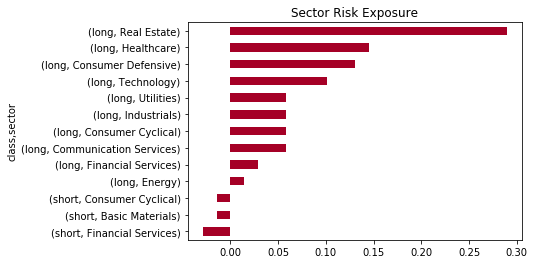

In [36]:
g_col = grouped.count().iloc[:,1]
(g_col.loc[(['bull', 'long']), :] / g_col.sum())\
    .append((g_col.loc[(['bear', 'short']), :] / g_col.sum()) * -1).sort_values()\
    .plot.barh(title='Sector Risk Exposure', cmap="RdYlGn");
plt.savefig('../images/ls_sector_exp.png', dpi=300, rot=0, bbox_inches='tight')

In [24]:
# Security level
show = ['class','ML_probability','forwardPE', 'industry',
        'targetMedianPrice', 'size']

vote_df.loc[ml_mask & vote_df['class'].isin(['bull', 'long']), :]\
    .sort_values(by='ML_probability', ascending=False)[show].head(max_rows)

,class,ML_probability,forwardPE,industry,targetMedianPrice,size
AVB,long,0.760,39.966,REIT - Residential,1.014,large
REG,long,0.733,42.457,REIT - Retail,1.032,large
FR,long,0.720,45.544,REIT - Industrial,1.001,mid
MAA,long,0.716,47.077,REIT - Residential,0.994,large
MA,long,0.711,26.541,Credit Services,1.042,large
KRC,long,0.704,39.371,REIT - Office,1.034,mid
CPT,long,0.698,49.288,REIT - Residential,1.024,large
KO,long,0.696,20.733,Beverages - Soft Drinks,1.072,large
ARE,long,0.695,54.473,REIT - Office,1.001,large
FRT,long,0.678,42.628,REIT - Retail,1.025,large


In [25]:
vote_df.loc[ml_mask & vote_df['class'].isin(['bear', 'short']), :]\
    .sort_values(by='ML_probability', ascending=False)[show].head(max_rows)

,class,ML_probability,forwardPE,industry,targetMedianPrice,size
NYCB,short,0.616,13.500,Savings & Cooperative Banks,0.989,mid
LPX,short,0.576,10.060,Building Materials,1.242,mid
CBS,short,0.568,7.870,Media - Diversified,1.143,large
C,short,0.556,7.700,Banks - Global,1.175,large


#### Company details

In [26]:
ticker = 'HUYA'

In [27]:
# Full company detail
vote_df.loc[ticker, :] if ticker in vote_df.index else None

class                                     long
ML_probability                           0.398
shortName                            HUYA Inc.
forwardPE                               28.244
trailingPE                                 NaN
marketCap                                4.735
regularMarketPrice                      23.160
sector                       Consumer Cyclical
industry                   Media - Diversified
country                                  China
pegRatio                                   NaN
shortPercentOfFloat                        NaN
earningsGrowth                             NaN
recommendationMean                       2.400
targetMeanPrice                          1.188
targetMedianPrice                        1.208
numberOfAnalystOpinions                  9.000
premDisc                                   NaN
growthRate                                 NaN
size                                       mid
Name: HUYA, dtype: object

In [28]:
# Company view across models
wgt_input = (ticker, 'soft_confidence')
print(f'Weighted ML score: {score_wgt_conf(wgt_input)}')
ticker_across_mls(ticker)

Weighted ML score: 0.3982867250370852


,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull,model
symbol,,,,,,,,,,,
HUYA,3,long,3,long,0.672,0.041,0.086,0.027,0.672,0.175,fin_data
HUYA,3,long,3,long,0.386,0.151,0.260,0.142,0.386,0.062,key_statistics
HUYA,3,long,3,long,0.473,0.031,0.096,0.162,0.473,0.239,eps_trend
HUYA,3,long,3,long,0.588,0.064,0.098,0.137,0.588,0.112,eps_estimates
HUYA,3,long,3,long,0.314,0.166,0.173,0.063,0.314,0.284,day_quote


#### Top picks by Model

In [38]:
# Useful for companys missing in multiple models...very early stage
show = ['symbol', 'soft_pred_label','soft_confidence', 'sector']

for key in fndm_dfs.keys():
    df = fndm_dfs[key]
    df.loc[:, 'sector'] = df.symbol.map(profile['sector'].to_dict())
    print()
    print(f'Showing results for {key.upper()}')
    print(f'Symbols: {df.symbol.shape[0]}')
    print(top_recomm_by_class(df, show_classes, 5)[show])


Showing results for PX_MOM
Symbols: 1164
           symbol soft_pred_label  soft_confidence              sector
pred_date                                                             
2019-04-10    CRH            bear            0.700     Basic Materials
2019-04-10    CMD            bear            0.747          Healthcare
2019-04-10    EMN            bear            0.734     Basic Materials
2019-04-10    RYN            bear            0.681     Basic Materials
2019-04-10    FUL            bear            0.715     Basic Materials
2019-04-10   NTES           short            0.442          Technology
2019-04-10   SMFG           short            0.444  Financial Services
2019-04-10    NEU           short            0.450     Basic Materials
2019-04-10    DLB           short            0.422   Consumer Cyclical
2019-04-10     UL           short            0.421  Consumer Defensive
2019-04-10     KO            long            0.672  Consumer Defensive
2019-04-10    SCI            long  

### Universe Intrinsic Value Analysis

In [30]:
iv_mapper = (1 - val_df.loc[(val_df['premDisc'] < 3) & (val_df['premDisc'] > 0), 'premDisc'])

In [31]:
iv_show = ['premDisc', 'forwardPE', 'targetMedianPrice', 'pegRatio', 'growthRate']
iv_df = add_desc_stats(iv_mapper.to_frame(), descriptive_cols)
iv_df.groupby(by=['sector', ]).agg(['count', 'min', 'median'])\
    .sort_values(by=(iv_show[0], 'median'))[iv_show]

premDisc              forwardPE                 \
                          count   min median     count     min median   
sector                                                                  
Financial Services           90 0.044  0.401        88   3.924 11.213   
Energy                       20 0.319  0.946        19   6.408 14.608   
Communication Services       11 0.529  0.990        10   4.579 10.217   
Consumer Cyclical            91 0.275  1.247        89   4.316 13.823   
Basic Materials              26 0.411  1.418        26   3.053 14.650   
Technology                   99 0.230  1.578        98 -54.143 18.509   
Industrials                  90 0.096  1.694        87   5.684 15.135   
Healthcare                   49 0.353  1.695        49 -14.332 14.221   
Utilities                    23 0.720  1.773        23   0.017 18.948   
Consumer Defensive           34 0.660  1.907        33   8.680 19.434   
Real Estate                   2 1.273  1.956         2  12.455 17.770   

                       targetMedianPrice              pegRatio                \
                                   count   min median    count    min median   
sector                                                                         
Financial Services                    88 0.549  1.103       88  0.159  1.222   
Energy                                20 0.985  1.184       19  0.088  1.547   
Communication Services                10 1.007  1.191       10  0.567    inf   
Consumer Cyclical                     89 0.776  1.070       89  0.174  2.526   
Basic Materials                       26 0.814  1.115       26  0.637  2.097   
Technology                            99 0.595  1.053       98   -inf  1.535   
Industrials                           89 0.867  1.076       87  0.177  2.736   
Healthcare                            49 0.829  1.104       49 -0.229  1.559   
Utilities                             23 0.830  1.021       23  0.002  3.335   
Consumer Defensive                    34 0.837  1.027       33  0.378  5.345   
Real Estate                            2 1.148  1.167        2  0.827  3.398   

                       growthRate               
                            count   min median  
sector                                          
Financial Services             90 0.000  0.100  
Energy                         20 0.000  0.070  
Communication Services         11 0.000  0.016  
Consumer Cyclical              91 0.000  0.057  
Basic Materials                26 0.000  0.059  
Technology                     99 0.000  0.158  
Industrials                    90 0.000  0.056  
Healthcare                     49 0.000  0.127  
Utilities                      23 0.000  0.052  
Consumer Defensive             34 0.000  0.035  
Real Estate                     2 0.039  0.095

In [32]:
ml_long = vote_df.loc[ml_mask & vote_df['class'].isin(['bull', 'long'])].index
ml_short = vote_df.loc[ml_mask & vote_df['class'].isin(['bear', 'short'])].index

In [33]:
iv_df.loc[iv_df.index.isin(ml_long) & (iv_df.premDisc < 1), iv_show].T

symbol,GOOG,GOOGL,SBUX,UTHR
premDisc,0.923,0.923,0.557,0.353
forwardPE,22.005,22.072,24.911,13.680
targetMedianPrice,1.144,1.119,0.927,0.984
pegRatio,1.011,1.014,0.688,0.513
growthRate,0.218,0.218,0.362,0.267


In [34]:
iv_df.loc[iv_df.index.isin(ml_short) & (iv_df.premDisc > 1), iv_show].T

symbol,CBS,NYCB
premDisc,2.988,1.474
forwardPE,7.870,13.500
targetMedianPrice,1.143,0.989
pegRatio,11.122,13.031
growthRate,0.007,0.010


#### Model audits

In [623]:
# Descriptive statistics for a given model
print(f'Descriptive statistics for {model.upper()}')
fndm_dfs[model].groupby(by=soft_vote).agg(agg_funcs).loc[fwd_ret_labels, 'soft_confidence']

Descriptive statistics for MICRO


,count,mean,median,max
soft_pred_label,,,,
bear,123,0.392,0.362,0.762
short,149,0.325,0.313,0.639
neutral,15,0.311,0.299,0.426
long,345,0.342,0.330,0.680
bull,547,0.388,0.368,0.783


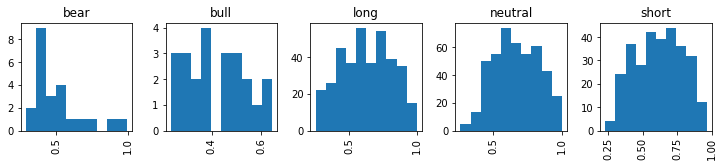

In [861]:
fndm_dfs['fin_data'].loc[:, [soft_vote, 'soft_confidence']].hist(
    by=soft_vote, figsize=(12,2), layout=(1,5));